In [1]:
import numpy as np
import matplotlib.pyplot as plt


This file is mainly for testing some equations and how they grow decay based on distance. 

## Strong forces

I need to test the constant for strong forces, the Yukawa potential seems like a good place to explore so I'll aim for that. (Which is also nice because if you change the constants you also get the coulomb forces, another aspect we need!)

I have two reasons to explore the proper constants:

1. In true theory, the strong force has two forms, inside a proton/neutron (inside a hadron) which remains constant or between a proton-neutron specifically this form, the one we need has exponential decay from about 1 fentometer to 3 fentometers. The strong force between the proton-neutron is represented as the transfer of a pion (a "meson" that is roughly between the mass of a proton and electron) between the neutron and proton. The proton-proton strong force is actually weaker than their electromagnetic force at the distance which leads into problem 2.

2. The strong forces need to be strong enough to outplay electromagnetic forces (binding a nucleus together) but also not so strong that a nucleus simply becomes a "black hole" Under normal conditions, particles within 3 fentometers should stay together, but outside of that range should stay apart. 

In [2]:
def yukawa_potential(r, C, R, lower_cutoff = 0.8e-6):
    return -C * np.exp(-r / R) / r

def coulomb_potential(r, scalar, q1, q2):
    return scalar * q1 * q2 / r

1.9692204146487665e-09
-7.893262866237594e-16


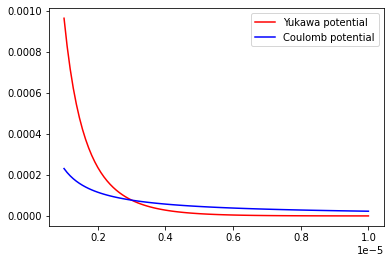

-0.0009640154298205886
0.00023102729690000002


In [3]:
C = 1 #Needs to be experimentally determined. Here we'll just force it so that the coloumb and yukawa potentials balance as 3 femtometers.

#I've seen this as 1.4e-15, here I've used 1.4e-3 since radius is in pm right now.
R = 1.4e-6 #This is the distance we expect the strong force to start becoming very insignificant.

#In all equations I think epsilon_0 should hold, given this is a well used constant.
scalar = 2.310272969e-10
q1 = 1
q2 = 1
# plt.plot(x, y2, label='Coulomb potential')

mod = 1

while True:
    error = yukawa_potential(3e-6, C, R) + coulomb_potential(3e-6, scalar, q1, q2)
    if np.abs(error) < 1e-15 or mod < 1e-10:
        break
    if error > 0:
        C += .1 * mod
    else:
        C -= .1 * mod
    mod *= 0.999

print(C)
print(error)

x = np.linspace(1e-6, 10e-6, 100)
y = yukawa_potential(x, C, R)
plt.plot(x, -y, label='Yukawa potential', color='red')

y2 = coulomb_potential(x, scalar, q1, q2)

plt.plot(x, y2, label='Coulomb potential', color="blue")

# plt.plot(x, y + y2, label='Total potential')

plt.legend()

#Make log scale
# plt.yscale('log')



plt.show()

print(min(y))
print(max(y2))



#The exact value needs to be tuned to interplay well with coloumb forces


In [4]:
print(yukawa_potential(9e-6, C, R))

print(coulomb_potential(9e-5, scalar, q1, q2))

-3.533122715641453e-07
2.5669699655555553e-06


In [5]:
print("yukawa_scalar:", C)
print("coulomb_scalar:", scalar)
print("yukawa_radius:", R)

yukawa_scalar: 1.9692204146487665e-09
coulomb_scalar: 2.310272969e-10
yukawa_radius: 1.4e-06


Precompue mass and meters.

Forces are in N's or kg * m / s^2. Rather than calculating the force in newton's, we can scale the mass to 1AU (the size of a proton) and the distance step defined in our simulation (currently nanometers). By doing this before hand we should be able to avoid some precision issues. Additionally, it should help with the very small timestep.

In [6]:
proton_mass = 1.6726219e-27
distance_scale = 1e-9

proton_electron_ratio = 1836.15267343

C_new = C / proton_mass * distance_scale
print("yukawa_precompute: ", C_new)

scalar_new = scalar / proton_mass * distance_scale
print("coulomb_precompute: ", scalar_new)

yukawa_precompute:  1177325499.9523602
coulomb_precompute:  138122845.87449202


Let's verify that the forces are still equal at 3 femtometers for the new constants:

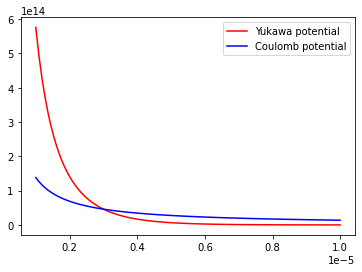

In [7]:
x = np.linspace(1e-6, 10e-6, 100)

y = yukawa_potential(x, C_new, R)
plt.plot(x, -y, label='Yukawa potential', color='red')

y2 = coulomb_potential(x, scalar_new, q1, q2)

plt.plot(x, y2, label='Coulomb potential', color="blue")

plt.legend()

Let's check the acceleration in nm/s^2 for electrons

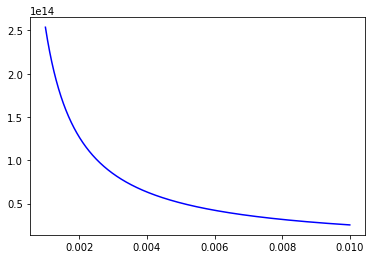

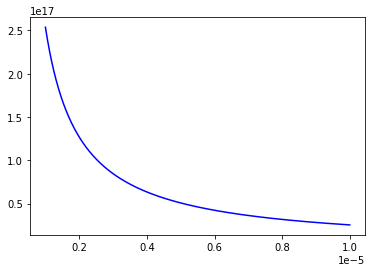

In [8]:
x = np.linspace(1e-3, 10e-3, 1000)
y = proton_electron_ratio*coulomb_potential(x, scalar_new, q1, q2)

plt.plot(x, y, label='Coulomb potential', color="blue")
plt.show()
x = np.linspace(1e-6, 10e-6, 1000)
y = proton_electron_ratio*coulomb_potential(x, scalar_new, q1, q2)

plt.plot(x, y, label='Coulomb potential', color="blue")
plt.show()

The coulomb force for electrons is insanely strong in the fentometer radius. We can either make the timestep 1e-18 to properly catch the value or add a cutoff for electrons at 1 picometer.

## Working Theory

My main problem with the proton electron only model is how to we keep the balance of some electrons within the nucleus and others outside the nucleus. Basically there's a big balancing act that needs to be accounted for. Frankly this method has the same balancing act, the main difference is I don't need to come up with a strong potential between a electron and proton since in reality it does not exist.

Here I'm thinking about reintroducing a neutron. 

1. Coulomb force between protons and electrons exist as expected

2. Strong forces are only calculated bewteen Protons and Neutrons. It is modeling with the yukawa equation. Which is inverse on radius with exponential decay. 

3. The only force acting on neutrons are the stong forces, which by design will only for a tight radius. A neutron should essentially move solely by a proton it is latched to. 

Electrons are not forced to be away from the nucleus. I decided to leave it like this because it actually seems closer to the actually electron interaction. We don't know where the electron is exactly, it just within a cloud around the nucleus. It can be really close or it can be farther away. The electron will want to get really close to a nucleus but it should move past it then get it's movement reset. If we opt to have a close cutoff for electrons, then interaction will be much clearer. 

# Number Specifics

## Coulomb specifics

Values references [this](http://labman.phys.utk.edu/phys222core/modules/m1/Electric%20Forces.html) website

$\epsilon_0 = 8.854187817e{-12}$

This means that $\dfrac{1}{4\pi\epsilon_0} = k_e = 9e9$ 
This value is in Newton meters squared per coloumb squared. It is necessary to scale this to our problem.

1. The distance between a proton and a neutron intra nucleus is 3 fentometers ($3e{-15}$ meters) which you need to multiply by this value squared. Having a decimal with 21 zeros is no good for calculation.

2. The distance between Hydrogen atoms is 110 picometers ($110e{-12}$ meters) at a minimum. 

The primary issue is if we use decimals that are too small we will get major error due to precision. 

In the coloumb equation qe = $1.602176634e{-19}$ In meters, assuming a radius of 1 meter this equation is practically useless. We need to scale this down based on both the size of the problem and also the amount of decimals we have at our disposal. 

Since the particles will just change qe's to be positive or negative we can precompute. Additionally, we want to scale to a relevant value. In femtometers this is: $2.310272969e2$ in picometers $2.31e-4$

## Yukawa specifics

The yukawa equation can actually be easily transformed for coulomb potential, it's just equation however the exponent is always 0 (massless system) then it is solely inverse of radius.

R represents the radius of the force. What is the range it is expected to strongest in. Force strong force this has been called 1.4 fm. Or $1.4e-15$ meters. Since the calculations are in nanometers, this is scaled to $1.4e-6$. The best I could find in terms of value for the front of the scalar was "obtained experimentally" so. As seen above I did just that. I numerically found the value for the scalar s.t. the force strong force balanced perfectly with the coulomb force between two protons at exactly 3 femtometers.



In [9]:
9e9 * 1.602176634e-19 * 1.602176634e-19 / (1e-12 * 1e-12)

0.00023102729698820125